## Structure-Property relationship using EELS data
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pycroscopy/DTMicroscope/blob/main/notebooks/STEM/3_structure_property_COLAB-Hackathon.ipynb)

  Establishing a clear understanding of the structure-property relationship is a cornerstone in materials science, as it enables us to predict and optimize material performance for a range of applications. This relationship provides insights into why materials exhibit certain behaviors under specific conditions, thus guiding the development of materials with tailored properties.

  However, bridging the gap between structure and properties is complex. Predicting what a material’s structure looks like from its properties—or vice versa—presents unique challenges, often requiring sophisticated data analysis and modeling. In this notebook, we’ll use Electron Energy Loss Spectroscopy (EELS) data to develop a workflow that can help us make these predictions.
  
  Our goal is to uncover insights into material behavior by building connections between what we see (structure) and how it performs (properties).

## Server setup

In [1]:
!pip install -q pyro5
!pip install -q scifireaders
!pip install -q sidpy
!pip install -q pynsid
!pip install -q git+https://github.com/pycroscopy/DTMicroscope.git
!pip install atomai
!pip install pytemlib

  Using cached atomai-0.8.1-py3-none-any.whl.metadata (15 kB)
  Using cached scikit_image-0.25.2-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached mendeleev-0.6.1-py2.py3-none-any.whl
  Using cached torchvision-0.24.1-cp310-cp310-win_amd64.whl.metadata (5.9 kB)
  Using cached progressbar2-4.5.0-py3-none-any.whl.metadata (16 kB)
  Using cached gpytorch-1.14.3-py3-none-any.whl.metadata (8.3 kB)
  Using cached pandas-2.3.3-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached sqlalchemy-2.0.45-cp310-cp310-win_amd64.whl.metadata (9.8 kB)
  Using cached pyfiglet-1.0.4-py3-none-any.whl.metadata (7.4 kB)
  Using cached jaxtyping-0.3.4-py3-none-any.whl.metadata (7.8 kB)
  Using cached linear_operator-0.6-py3-none-any.whl.metadata (15 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached python_utils-3.9.1-p

In [ ]:
!run_server_stem

## Client side starts

In [1]:
import matplotlib.pylab as plt
import numpy as np
import Pyro5.api
import cv2
from atomai import utils

### 1. connect to server

In [2]:
# Connect to the microscope server
uri = "PYRO:microscope.server@localhost:9091"
mic_server = Pyro5.api.Proxy(uri)
out_dir = "."

### 2. Download and Register dataset

#### 2a. download dataset

In [7]:
!pip install wget

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9712 sha256=d8559cd1bacab09a64d1e9c9c00cdeea8de9d92225a386ac054b66b4371fea32
  Stored in directory: c:\users\jcruanes\appdata\local\pip\cache\wheels\8b\f1\7f\5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [13]:
# download dataset
!wget https://github.com/pycroscopy/DTMicroscope/raw/utk/data/STEM/SI/test_stem.h5 --no-check-certificate

--2025-12-18 10:26:55--  https://github.com/pycroscopy/DTMicroscope/raw/utk/data/STEM/SI/test_stem.h5
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
  Self-signed certificate encountered.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pycroscopy/DTMicroscope/utk/data/STEM/SI/test_stem.h5 [following]
--2025-12-18 10:26:56--  https://raw.githubusercontent.com/pycroscopy/DTMicroscope/utk/data/STEM/SI/test_stem.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
  Self-signed certificate encountered.
HTTP request sent, awaiting response... 200 OK
Length: 55702624 (53M) [application/octet-stream]
Saving to: 'test_stem.h5'

     0K .......... .......... .......... .......... ..........  0% 1.43M 37s
 

In [14]:
import os
ruta = os.path.abspath("test_stem.h5")
print(ruta)

c:\Users\jcruanes\Downloads\DTMicroscope-main\DTMicroscope-main\notebooks\STEM\test_stem.h5


#### 2b. register dataset in the DigitalTwin

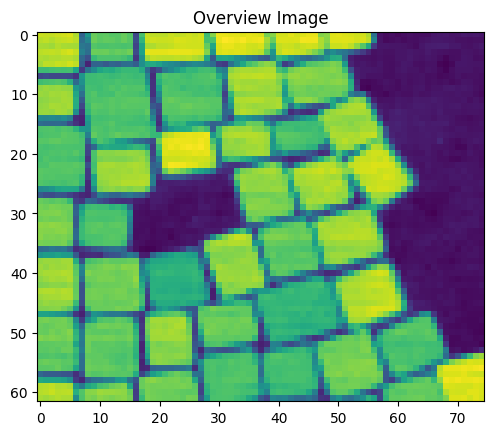

In [15]:
# Initialize microscope and register data
mic_server.initialize_microscope("STEM")
mic_server.register_data(ruta)

# Get overview image
array_list, shape, dtype = mic_server.get_overview_image()
im_array = np.array(array_list, dtype=dtype).reshape(shape)

# Display the overview image
plt.imshow(im_array)
# plt.axis("off")
plt.title("Overview Image")
plt.show()


### 3. Get spectra at all pixels

Let's extract the spectrum from each pixel in the image and store it in a 3D array.

In [16]:
height, width = im_array.shape

spectra = []
locations = []
for x in range(height):
    for y in range(width):
        array_list, shape, dtype = mic_server.get_point_data("Channel_001", x, y)
        spectrum = np.array(array_list, dtype=dtype).reshape(shape)
        spectra.append(spectrum)
        locations.append((x, y))

spectra = np.array(spectra).reshape(height, width, -1)  # Convert list of spectra to a NumPy array
spectra.shape



(62, 75, 1496)

In [17]:
def preprocess_and_extract_patches(im_array, spectra, window_size=20, step=1):
    """
    Normalize input image and spectra, generate coordinate grid, and extract image patches and corresponding spectra.

    Parameters:
    im_array (np.array): 2D image array to extract patches from.
    spectra (np.array): Array of spectra corresponding to the image.
    window_size (int): Size of the window for patches.
    step (int): Step size for sliding window.

    Returns:
    features (np.array): Extracted image patches.
    targets (np.array): Averaged spectra for each patch.
    indices (np.array): Coordinates of each patch.
    """

    # Normalization functions for image and spectra maps
    norm_ = lambda x: (x - x.min()) / np.ptp(x)
    img = norm_(im_array)
    specim = norm_(spectra)

    # Generate coordinates grid
    coordinates = utils.get_coord_grid(img, step=step, return_dict=False)

    # Extract image patches and corresponding spectra
    features, targets, indices = utils.extract_patches_and_spectra(
        specim, img, coordinates=coordinates, window_size=window_size, avg_pool=1
    )

    return features, targets, indices


We use the extract_patches_and_spectra function from atomAI to extract patches based on a specified window size, along with their corresponding spectra. For each patch, all spectra from that patch are averaged to produce a single mean spectrum, resulting in one representative spectrum for each image patch

In [18]:
#Features are the image patches and targets are the spectra for teh corresponding patch
features, targets, indices = preprocess_and_extract_patches(im_array, spectra, window_size=20, step=1)
features.shape, targets.shape

c:\Users\jcruanes\.conda\envs\HackathonNew\lib\site-packages\atomai\utils\img.py:450: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  spectra = torch.tensor(spectra).unsqueeze(1)


((2408, 20, 20), (2408, 1496))

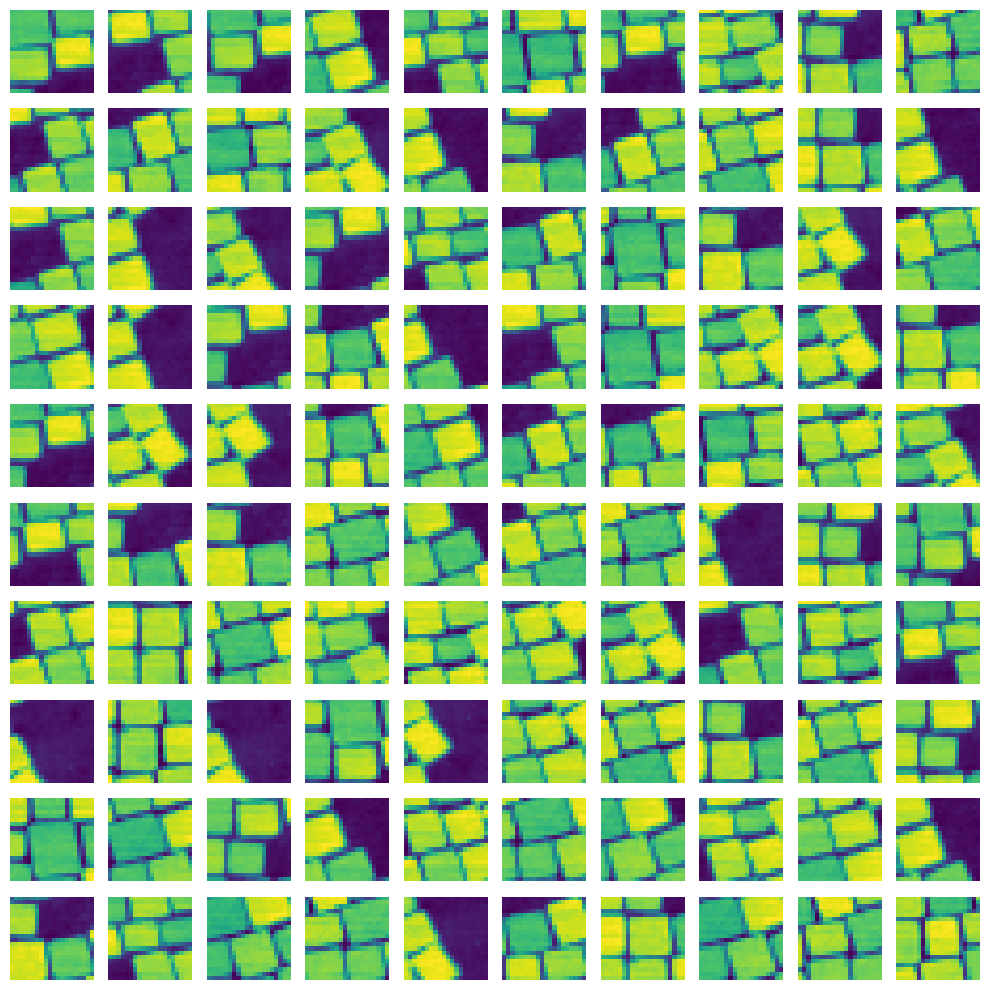

In [23]:
import random

# Select 20 random patches
num_patches_to_show = 100
random_indices = random.sample(range(len(features)), num_patches_to_show)
selected_patches = features[random_indices]

output_dir = "parches_guardados"
os.makedirs(output_dir, exist_ok=True)


# Create a 4x5 grid for displaying the patches
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

# Flatten the axes array for easier iteration
axes = axes.ravel()


# Display the selected patches
for i, patch in enumerate(selected_patches):
    axes[i].imshow(patch)
    axes[i].axis('off')
    filename = os.path.join(output_dir, f"Imagen_{i+1}.png")
    plt.imsave(filename, patch)

# Turn off any remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

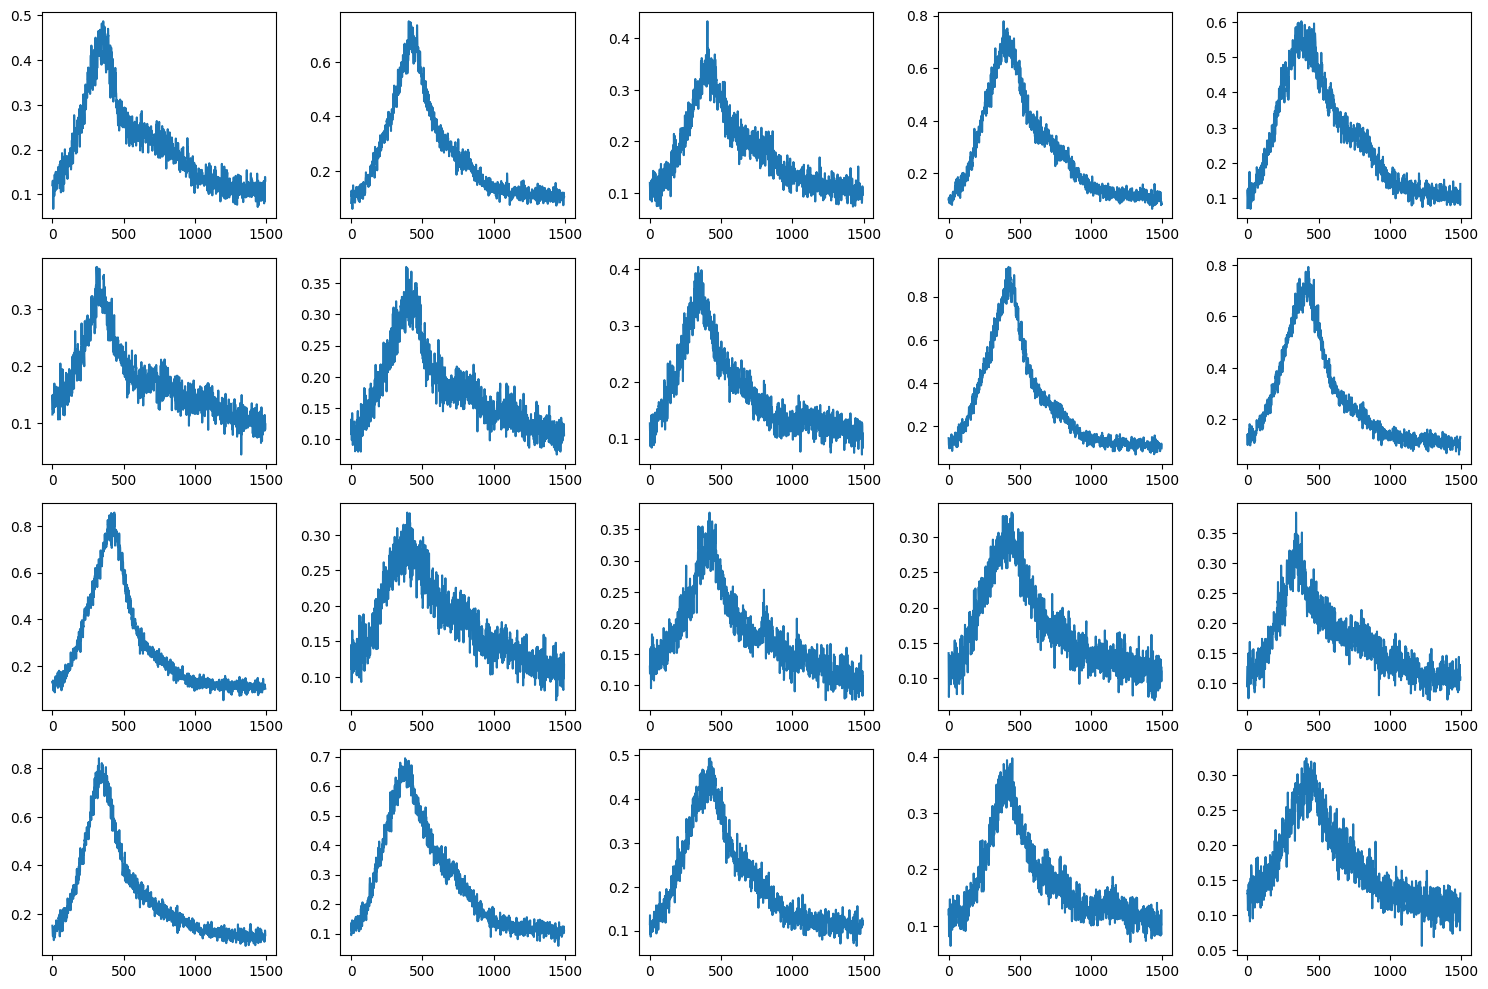

In [20]:
# Select corresponding targets for the random indices
selected_targets = targets[random_indices]

# Create a 4x5 grid for displaying the targets
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.ravel()  # Flatten the axes array

# Plot the selected targets
for i, target in enumerate(selected_targets):
    axes[i].plot(target)  # Plot the target as a line plot
    axes[i].axis('on')  # Keep axis labels

# Turn off any remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()